In [16]:
import imutils
import copy

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import time

import cv2

from PIL import Image 
from sklearn.preprocessing import OneHotEncoder 

In [2]:
def contour(image , plot = False):
    # Converting to Gray scale images
    gs_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Converting the image to Binary for easy seperation of object from background
    
    # Blurring the image (Image smoothing)
    gs_img = cv2.GaussianBlur(gs_img, (5,5),0)
    
    # Converting the grayscale image to binary image
    bin_img = cv2.threshold(gs_img, 50, 255, cv2.THRESH_BINARY)[1]
    
    # Removing the noise from image
    bin_img = cv2.erode(bin_img, None, iterations=2)
    bin_img = cv2.dilate(bin_img, None, iterations=2)
    
    # Finding the contour of image
    cntr = cv2.findContours(bin_img.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)      
    
    # Get largest contour
    cntr = imutils.grab_contours(cntr)
    ct = max(cntr, key=cv2.contourArea)
    
    # Limiting the image by extreme points.
    extreme_left = tuple(ct[ct[:,:,0].argmin()][0])
    extreme_right = tuple(ct[ct[:,:,0].argmax()][0])
    extreme_top = tuple(ct[ct[:,:,1].argmin()][0])
    extreme_bottom = tuple(ct[ct[:,:,1].argmax()][0])
    
    # Processed image
    proc_img = image[extreme_top[1]:extreme_bottom[1],extreme_left[0]:extreme_right[0]]
    
    # Comparing original and processed images
    if plot:
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(image)
        
        plt.tick_params()
        plt.title("Org Image")
        
        
        plt.subplot(1,2,2)
        plt.imshow(proc_img)
        
        plt.tick_params()
        plt.title("Proc Image")
        plt.show()
        
    return proc_img

In [3]:
import numpy as np
import pandas as pd

import os
from os import listdir

malignant_paths = []
benign_paths = []

dataset = []
labels = []

data_set_path = 'E:/UM_Dearborn/Classes/Sem 2/AI/Assignment/Term Project/DataSet/'
malignant_tumours = data_set_path + 'yes/'
benign_tumours = data_set_path + 'no/'

In [ ]:
# Run only once
# Denoising the images

malignant_paths = []
benign_paths = []

for file in os.listdir(malignant_tumours):
    malignant_paths.append(malignant_tumours+file)
            
for file in os.listdir(benign_tumours):
    benign_paths.append(benign_tumours+file)

# print(np.array(malignant_paths))
# print(np.array(benign_paths))

for path in malignant_paths+benign_paths:
    print(path)
    img = cv2.imread(path)
    img = contour(img, False)
    cv2.imwrite(path, img)
    
    img = Image.open(path)
    img = img.resize((128,128))
    img.save(path)

In [4]:
# On hot encoding
# 0 = Benign
# 1 = Malignant
encoder = OneHotEncoder()
encoder.fit([[0], [1]]) 
print(encoder.categories_)
print(encoder.categories)

[array([0, 1])]
auto


In [5]:
malignant_paths = []
benign_paths = []

for file in os.listdir(malignant_tumours):
    if '.jpg' in file:
        malignant_paths.append(malignant_tumours+file)
            
for file in os.listdir(benign_tumours):
    if '.jpg' in file:
        benign_paths.append(benign_tumours+file)

In [6]:
# Preparing the dataset - Malignant
for path in malignant_paths:
    img = Image.open(path)
    img = np.array(img)
    if(img.shape == (128,128,3)):
        dataset.append(np.array(img))
        labels.append(encoder.transform([[1]]).toarray())

In [7]:
# Preparing the dataset - Benign
for path in benign_paths:
    img = Image.open(path)
    img = np.array(img)
    if(img.shape == (128,128,3)):
        dataset.append(np.array(img))
        labels.append(encoder.transform([[0]]).toarray())

In [8]:
dataset = np.array(dataset)
dataset.shape

(171, 128, 128, 3)

In [9]:
labels = np.array(labels)
labels = labels.reshape(len(labels),2)
labels.shape

(171, 2)

In [32]:
x_train,x_test,y_train,y_test = train_test_split(dataset, labels, test_size=0.25, shuffle=True, random_state=0)

In [34]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(128, 128, 3), padding = 'Same'))
model.add(Conv2D(32, kernel_size=(2, 2),  activation ='relu', padding = 'Same'))


model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss = "categorical_crossentropy", optimizer='Adamax')
print(model.summary())

history = model.fit(x_train, y_train, epochs = 30, batch_size = 40, verbose = 1, use_multiprocessing = True, validation_data = (x_test, y_test))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 128, 32)      416       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 32)      4128      
_________________________________________________________________
batch_normalization_6 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 64)        8256      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 64)       

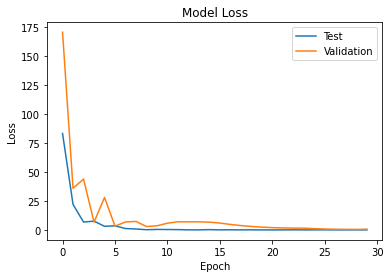

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Validation'], loc='upper right')
plt.show()

In [31]:
# x_train,x_test,y_train,y_test

y_train_inv_transformed = encoder.inverse_transform(y_train).flatten()
y_pred = np.argmax(model.predict(x_train), axis=-1)

cm = confusion_matrix(y_train_inv_transformed, y_pred)
print('Confusion Matrix: Training set\n',cm,'\n')
print('Accuracy : Training set: ',accuracy_score(y_train_inv_transformed,y_pred),'\n\n')

y_pred = np.argmax(model.predict(x_test), axis=-1)
y_test_inv_transformed = encoder.inverse_transform(y_test).flatten()

cm = confusion_matrix(y_test_inv_transformed, y_pred)
print('Confusion Matrix: Test set\n',cm,'\n')
print('Accuracy : Test set: ',accuracy_score(y_test_inv_transformed,y_pred))

Confusion Matrix: Training set
 [[74  0]
 [12 67]] 

Accuracy : Training set:  0.9215686274509803 


Confusion Matrix: Test set
 [[10  1]
 [ 2  5]] 

Accuracy : Test set:  0.8333333333333334


# Sample Image took John Hopkins Medicine Pathology portal and predicted the results

In [36]:
malignant_paths = ['C:\\Users\\rajku\\Desktop\\brain-tumor-overview.jpg']
benign_paths = []

# print(np.array(malignant_paths))
# print(np.array(benign_paths))

for path in malignant_paths+benign_paths:
    print(path)
    img = cv2.imread(path)
    img = contour(img, False)
    cv2.imwrite(path, img)
    
    img = Image.open(path)
    img = img.resize((128,128))
    img.save(path)

C:\Users\rajku\Desktop\brain-tumor-overview.jpg


In [41]:
y_test_real = []
img = Image.open('C:\\Users\\rajku\\Desktop\\brain-tumor-overview.jpg')
img = np.array(img)
if(img.shape == (128,128,3)):
    y_test_real.append(np.array(img))

y_test_real = np.array(y_test_real)
y_test_real.shape

(1, 128, 128, 3)

In [44]:
np.argmax(model.predict(y_test_real), axis=-1)[0]

1